
# COSC2667 – Computational Machine Learning
## Assignment II – Machine Learning Project 
### Jigar Mangukiya | S3715807
### Semester 1, 2020 Master of Data Science
### Royal Melbourne Institute of Technology
<br>

### Loading required library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import time
import shutil
import zipfile
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from keras.utils import np_utils
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Activation, Lambda, Input, InputLayer

Using TensorFlow backend.


# 1. Loading the dataset

In [3]:
# Extract the zip
# with zipfile.ZipFile('../Datasets/trafficsigns_dataset-1.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')   

In [4]:
# # Create Dataframe from the directory datasets

# Read the image paths and other details
def DataLoad():
    image_list = []
    for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True): #assuming gif
        sign = filepath.split("\\")[-2]
        shape = filepath.split("\\")[-3]
        image_list.append((filepath, shape, sign ))

    # Dataframe
    trafficDF = pd.DataFrame(data=image_list, columns=['path', 'shape', 'sign' ])

    # Assign a number ot string names
    shapeMapping = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
    signMapping = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10,
               'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

    trafficDF['sign_num'] = trafficDF['sign'].map(signMapping, na_action='ignore')
    trafficDF['shape_num'] = trafficDF['shape'].map(shapeMapping, na_action='ignore')
    return trafficDF

# Confirm the proper loading of data by examining the DF
trafficDF = DataLoad()
trafficDF.head(2)
print(trafficDF.shape)

(3699, 5)


# 2. Initial exploration

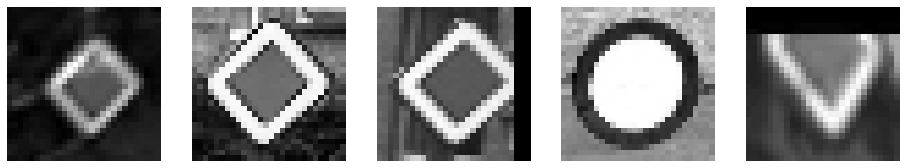

In [5]:
# Check some random images to have a better understanding of the images

r_inx = np.random.choice(1000, 5)
rand_data = trafficDF.loc[r_inx,'path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

## Distribution by target type

Examining the distribution by type of the data, it is evident that the values are unevenly spread. 
This creates multitude of the problems while training and testing models and two of the major problems are,
*  Under-represented class will potentially suffer from high level of inaccuracy due to algorithm not getting enough training examples
*  There might not be enough examples of under-represented class to thouroughly validate or test the performance of model for that class

The unbalanced nature of the data can be observed in following two plots, where shapes "diamond" and "hex" classes have significantly fewer instances than "round" or "triangle" classes. Simillarly, "stop", "crossing" and "roundabout" classes are significantly under-represented comapred to other classes like "warning" and "noentry".

### (1) Distribution of images by shape target

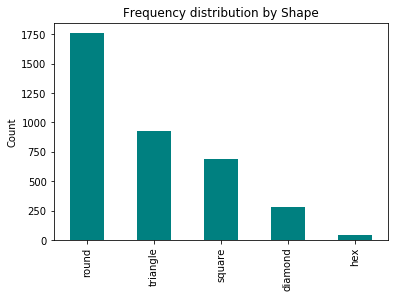

In [6]:
# Check frequency distribution of the shape classes

shapeCount = trafficDF['shape'].value_counts()
# print(shapeCount)
shapeCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Shape')
plt.ylabel('Count')
plt.show();

### (2) Distribution of images by sign target

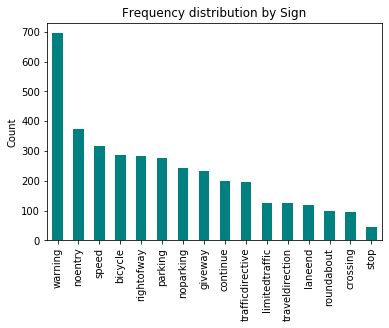

In [7]:
# Check frequency distribution of sign classes

signCount = trafficDF['sign'].value_counts()
# print(signCount)
signCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Sign')
plt.ylabel('Count')
plt.show();

## Augment and add images to Hex class

### Hanadling the unbalanced dataset

The unbalanced distribution of both target variables needs to be rectified. Model will require roughly even distribution of the instances in training dataset. To create the large enough training set, while also keeping enough instances aside for testing set to measure the correct performance will not be possible. especially considering instance count in smallest target class is around 45. Next section augments the images to create new images and resolving very low observations

In [8]:
def shapeGenerateAugmentations(shape, noOfImages):
    # Initialising the ImageDataGenerator class. 
    # We will pass in the augmentation parameters in the constructor. 
    datagen = ImageDataGenerator( 
            rotation_range = 15, 
            shear_range = 0.3, 
            zoom_range = 0.3,
            brightness_range = (0.5, 1.5)) 

    # Loading a sample image  

    for img_path in list(trafficDF[trafficDF['shape']==shape][:noOfImages//4]['path']):
        img = load_img(img_path)  
        print(img)
        # Converting the input sample image to an array 
        x = img_to_array(img) 
        # Reshaping the input image 
        x = x.reshape((1, ) + x.shape)  

        # Generating and saving 5 augmented samples  
        # using the above defined parameters.  
        i = 0
        for batch in datagen.flow(x, batch_size = 1, 
                                  save_to_dir ='./trafficsigns_dataset\\hex\\stop\\',  
                                  save_prefix ='aug_', save_format ='png'): 
            i += 1
            if i > 4: 
                break

In [ ]:
shapeGenerateAugmentations('hex',200)

# 3. Modelling - Shape

In [10]:
# Use stratified sampling to partition the dataframe into train, validation and test partitions
# Use shape classes for stratification

shapeHyperTrainDF, shapeTestDF = train_test_split(trafficDF, random_state=677, test_size=0.2, stratify=trafficDF['shape_num'])
shapeTrainDF, shapeValidDF = train_test_split(shapeHyperTrainDF, random_state=41, test_size=0.2, stratify=shapeHyperTrainDF['shape_num'])

shapeTrainDF['shape_num'] = shapeTrainDF['shape_num'].astype('category')
shapeValidDF['shape_num'] = shapeValidDF['shape_num'].astype('category')
shapeTestDF['shape_num'] = shapeTestDF['shape_num'].astype('category')

### Image generators
Using image generators for efficient loading of image data in batches on the fly, so no memeory overhead is created while training or testing the models

As of now, there is no augmentation created for the images, only scaling is performed by dividing the image by 255, to bring the values between 0 & 1 for faster processing

Generators are reading the images in 28 * 28 configuration along with labels, for testing the shuffle is turned off to generate classifciation reports 

In [11]:
# Data generators for batching and efficient processing

shapeBatchSize = 28

shapeTrainDatagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# shapeTrainDatagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2,  zoom_range=0.2,  rotation_range=10, data_format='channels_last')
shapeValidationDatagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

shapeTestDatagen = ImageDataGenerator(rescale=1. / 255)


shapeTrainGenerator = shapeTrainDatagen.flow_from_dataframe(
        dataframe=shapeTrainDF,
        directory='./',
        x_col="path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=shapeBatchSize,
        class_mode='categorical')

shapeValidationGenerator = shapeValidationDatagen.flow_from_dataframe(
        dataframe=shapeValidDF,
        directory='./',
        x_col="path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=shapeBatchSize,
        class_mode='categorical')

shapeTestGenerator = shapeTestDatagen.flow_from_dataframe(
        dataframe=shapeTestDF,
        directory='./',
        x_col="path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=shapeBatchSize,
        class_mode='categorical',
        shuffle=False)

Found 2367 validated image filenames belonging to 5 classes.
Found 592 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


## Baseline model - Simple Neural Network

This function returns a basic neural network classifier with parameterised output layer size for reusability,

input layer expects the input in 28 * 28 configuration and flattens it.

there is one dense (fully connected) hidden layer, with sigmoid activation function

Output layer of <"parameter"> size is created with softmax activation function, which provides convinience of providing class probability that sums to 1

Model uses standard Stochaistic Gradient Descent optimizer with learning rate 0.01 which was empirically set.

it usess categorical crossentropy loss function and measures accuracy metric.

In [65]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def simpleNeuralNetwork(outLayerSize):
    # Input layer
    input_ = Input(shape=(28, 28, 3))
    input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)   
    x = Flatten()(input_slice)  

    # Hidden layer
    h = Dense(64)(x)
    h = Activation('relu')(h)

    # Output layer
    out_ = Dense(outLayerSize)(h)
    out_ = Activation('softmax')(out_)

    # Define model
    model_orig = Model(inputs=input_, outputs=out_)

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_orig.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


    # model_orig.summary()
    return model_orig

In [13]:
# Method provides interface to fit the model with train and validation generators

def fitModel(_model, _shapeTrainGenerator, _val_generator, _num_train_samples, _num_val_samples,
                        _batch_size, _epochs, _model_name):
    start_time = time.time()
    _hist = _model.fit_generator(_shapeTrainGenerator,
                                 steps_per_epoch=_num_train_samples // _batch_size,
                                 epochs=_epochs,
                                 validation_data=_val_generator,
                                 validation_steps=_num_val_samples // _batch_size)

#     plot_accuracy(_hist, _epochs, _model_name)
#     _model.save("./models/" + _model_name + ".h5")
    print("Model Training Completed in ", str(round(time.time()- start_time,2))," seconds")
    return _model, _hist

In [55]:
# Accuracy and loss plots for understanding performance profile of model over all epochs

def plot_accuracy(_model_hist, _epochs, _name):
    plt.style.use("ggplot")
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, _epochs), _model_hist.history["loss"], label="train_loss")
    plt.plot(np.arange(0, _epochs), _model_hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss of Belgian Traffic Shape Dataset\n Model: " + _name)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, _epochs), _model_hist.history["acc"], label="train_acc")
    plt.plot(np.arange(0, _epochs), _model_hist.history["val_acc"], label="val_acc")
    plt.title("Training Accuracy of Belgian Traffic Shape Dataset\n Model: " + _name)
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")

    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig("./figures/" + _name + ".png")

    return None

## Baseline Model - training

In [69]:
epochs = 150

img_width, img_height = 28, 28

shapeModelNN = simpleNeuralNetwork(5)

# fit and evaluate the model
shapeModelNN, shapeModelNNPerformance = fitModel(shapeModelNN, shapeTrainGenerator, shapeValidationGenerator, len(shapeTrainDF), len(shapeValidDF), shapeBatchSize, epochs, "Neural Network - Shape")

Epoch 1/150
85/85 [==============================] - 1s 14ms/step - loss: 0.8067 - acc: 0.7381 - precision_6: 0.8407 - recall_6: 0.5661 - val_loss: 0.4904 - val_acc: 0.8547 - val_precision_6: 0.9158 - val_recall_6: 0.7720
Epoch 2/150
85/85 [==============================] - 1s 11ms/step - loss: 0.4023 - acc: 0.8868 - precision_6: 0.9130 - recall_6: 0.8251 - val_loss: 0.3545 - val_acc: 0.9139 - val_precision_6: 0.9521 - val_recall_6: 0.8395
Epoch 3/150
85/85 [==============================] - 1s 11ms/step - loss: 0.2958 - acc: 0.9176 - precision_6: 0.9359 - recall_6: 0.8885 - val_loss: 0.2672 - val_acc: 0.9189 - val_precision_6: 0.9425 - val_recall_6: 0.8868
Epoch 4/150
85/85 [==============================] - 1s 14ms/step - loss: 0.2475 - acc: 0.9307 - precision_6: 0.9488 - recall_6: 0.9079 - val_loss: 0.2226 - val_acc: 0.9426 - val_precision_6: 0.9529 - val_recall_6: 0.9223
Epoch 5/150
85/85 [==============================] - 1s 13ms/step - loss: 0.1985 - acc: 0.9468 - precision_6: 0.



test loss, test acc: [0.15809619425002625, 0.9594595, 0.9594595, 0.9594595] 





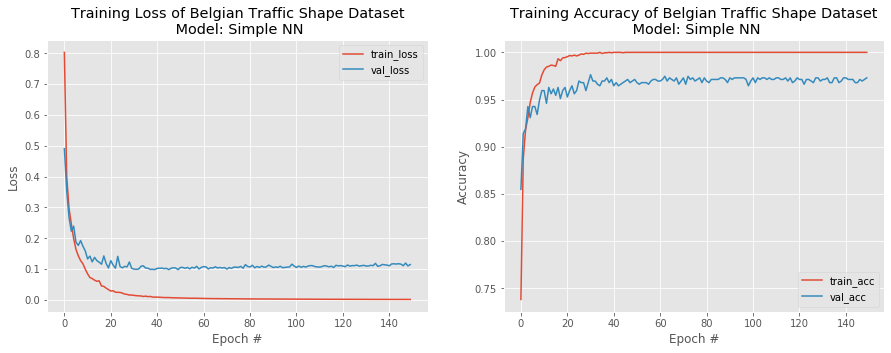

In [70]:
shapeTestNNResult = shapeModelNN.evaluate_generator(shapeTestGenerator, len(shapeTestDF))
print('\n\ntest loss, test acc:', shapeTestNNResult, "\n\n\n")
plot_accuracy(shapeModelNNPerformance, epochs, "Simple NN")

### Baseline model evaluation

Model performs well in training accuracy but however shows some signs of over-fitting in the validation set. To tackle the over-fitting next models can be used with augmentation in image generators.

# 4. CNN Model

- Model loosely based on VGG 13 design with parameterized conv. layers for ease of tuning

In [17]:
#define CNN modelCNN to be used for training our image classificatin data
def shapeCNN(denseLayerSizes, filters, kernelSize, poolSize, optimizer='rmsprop', init='glorot_uniform', learningRate = 0.0001, momentumVal = 0.9, cLayers = 3):
    modelCNN = ""  
    modelCNN = Sequential()
    
    # Input layer
    modelCNN.add(InputLayer(input_shape=(28, 28,3)))
    modelCNN.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))

    # Dynamically add convulation and pooling layers as per hyper-parameter cLayers (minimum 1)
    for i in range(cLayers):
        multiplier = 2 * i if i > 0 else 1
        modelCNN.add(Conv2D((multiplier) * filters, kernelSize, padding='same'))
        modelCNN.add(Activation('relu'))
        modelCNN.add(Conv2D((multiplier) * filters, kernelSize, padding='same'))
        modelCNN.add(Activation('relu'))
        modelCNN.add(MaxPooling2D(pool_size=poolSize))
        modelCNN.add(Dropout(0.125))

    # MLP
    modelCNN.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    for layer_size in denseLayerSizes:
        modelCNN.add(Dense(layer_size))
        modelCNN.add(Activation('relu'))
    modelCNN.add(Dropout(0.4))
    modelCNN.add(Dense(5))
    modelCNN.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(lr=learningRate, decay=1e-6)
#     sgd = optimizers.SGD(lr=learningRate, decay=1e-6, momentum= momentumVal, nesterov=True)
    modelCNN.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    # save the weights so that we can start from the same place when tring different configurations
    modelCNN.save_weights('modelCNN.h5')
    
#     modelCNN.summary()
        
    return modelCNN

### Augmenting to prevent overfitting

In [18]:
# Augmenting

shapeTrainDatagenAug = ImageDataGenerator(rescale=1. / 255, shear_range=0.5,  zoom_range=0.5,  rotation_range=30, data_format='channels_last')


shapeTrainGeneratorAug = shapeTrainDatagenAug.flow_from_dataframe(
        dataframe=shapeTrainDF,
        directory='./',
        x_col="path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=shapeBatchSize,
        class_mode='categorical')

Found 2367 validated image filenames belonging to 5 classes.


## CNN - training shape - Dry run with augmented images

In [19]:
shapeModelCNNAug = shapeCNN(denseLayerSizes = [512], filters = 8, kernelSize =3, poolSize = 2)

# # fit and evaluate the model
shapeModelCNNAug, shapeModelCNNAugPerformance = fitModel(shapeModelCNNAug, shapeTrainGenerator, shapeValidationGenerator, len(shapeTrainDF), len(shapeValidDF), shapeBatchSize, epochs, "CNN - Shape")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/120
85/85 [==============================] - 5s 60ms/step - loss: 1.3362 - acc: 0.4651 - precision_1: 0.4804 - recall_1: 0.0984 - val_loss: 1.2750 - val_acc: 0.4764 - val_precision_1: 0.5376 - val_recall_1: 0.0845
Epoch 2/120
85/85 [==============================] - 1s 14ms/step - loss: 1.2610 - acc: 0.4791 - precision_1: 0.5377 - recall_1: 0.1627 - val_loss: 1.2409 - val_acc: 0.4764 - val_precision_1: 0.5837 - val_recall_1: 0.2297
Epoch 3/120
85/85 [==============================] - 1s 13ms/step - loss: 1.2343 - acc: 0.4943 - precision_1: 0.5659 - recall_1: 0.2087 - val_loss: 1.2084 - val_acc: 0.5405 - val_precision_1: 0.7500 - val_recall_1: 0.0963
Epoch 4/120
85/85 [==============================] - 1s 14ms/step - loss: 1.1971 - acc: 0.5213 - precision_1: 0.6117 - recall_1: 0.2210 - val_loss: 1.1369 - val_acc: 0.5693 - val_precision_1: 0.6961 - val_recall_1: 0.23

test loss, test acc: [0.040608087890345985, 0.9864865, 0.9891599, 0.9864865]


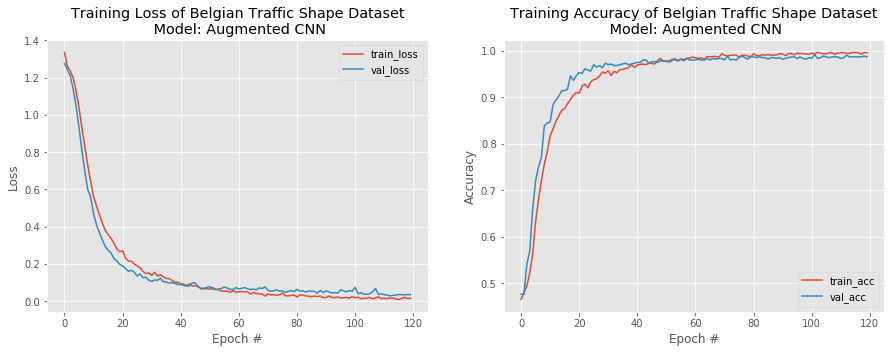

In [20]:
shapeTestCNNAugEval = shapeModelCNNAug.evaluate_generator(shapeTestGenerator, len(shapeTestDF))
print('test loss, test acc:', shapeTestCNNAugEval)
plot_accuracy(shapeModelCNNAugPerformance, epochs, "Augmented CNN")

In [21]:
shapeTestGenerator.reset()

pred=shapeModelCNNAug.predict_generator(shapeTestGenerator,verbose=1,steps=740/74)

predicted_class_indices=np.argmax(pred,axis=1)

target_names = ['diamond', 'hex', 'round', 'square', 'triangle']
print(classification_report(shapeTestGenerator.classes,predicted_class_indices, target_names=target_names))

27/27 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.96      0.98        56
         hex       1.00      0.78      0.88         9
       round       0.98      1.00      0.99       352
      square       1.00      0.97      0.99       138
    triangle       0.99      0.99      0.99       185

    accuracy                           0.99       740
   macro avg       0.99      0.94      0.96       740
weighted avg       0.99      0.99      0.99       740



# 5. Hyper parameter tuning - Shape Target

In [22]:
shapeHyperTrainDF.head()

,path,shape,sign,sign_num,shape_num
1135,./trafficsigns_dataset\round\noparking\00530_0...,round,noparking,5,2
3423,./trafficsigns_dataset\triangle\warning\01077_...,triangle,warning,15,4
2627,./trafficsigns_dataset\square\parking\00804_00...,square,parking,13,3
1698,./trafficsigns_dataset\round\speed\01773_00001...,round,speed,7,2
497,./trafficsigns_dataset\round\bicycle\00904_000...,round,bicycle,2,2


In [23]:
# Data preparation for tuning
shapeHyperTrainImagesList = []
shapeHyperTestImagesList = []


# Data of feature(image_path) and target variables(lables of shape and type)
imgPath = shapeHyperTrainDF.iloc[:,0]
shapeHyperTrainLabels = shapeHyperTrainDF.iloc[:,4]

# Loading images into numpy array
for i in imgPath:
    tempImage = image.load_img(i, target_size=(28,28,1), grayscale=False)
    tempImage = image.img_to_array(tempImage)
    tempImage = tempImage/255
    shapeHyperTrainImagesList.append(tempImage)

shapeHyperTrainImages = np.array(shapeHyperTrainImagesList)

# Coverting lables type to catagorical
shapeHyperTrainLabels = tf.keras.utils.to_categorical(shapeHyperTrainLabels)
# shapeHyperTestLabels = tf.keras.utils.to_categorical(shapeHyperTestLabels)

## Tuning code is commented out as it takes a long time to run

In [24]:
# (denseLayerSizes, filters, kernelSize, poolSize, optimizer='rmsprop', init='glorot_uniform')

shapeHyperModel = KerasClassifier(build_fn=shapeCNN, verbose=True)

epochs = [100,120]
filters = [8,16]
poolSize = [2,3]
kernelSize = [3, 5]
batchSize = [28, 32,56]
cLayers = [1,2,3]
denseLayerSize = [[1024], [1024,512,256], [1024, 512]]
learnRate = [0.001, 0.01, 0.1, 1]


paramGrid = dict(batch_size=batchSize, epochs=epochs, 
    denseLayerSizes = denseLayerSize, filters = filters , kernelSize = kernelSize , poolSize = poolSize, cLayers = cLayers, learningRate = learnRate)

grid = RandomizedSearchCV(estimator=shapeHyperModel , param_distributions=paramGrid, n_jobs=1, n_iter= 20, cv=3)

start_time = time.time()
# grid_result = grid.fit(shapeHyperTrainImages, np.array(shapeHyperTrainLabels))
print("tuning time", str(time.time() - start_time), "seconds")

tuning time 0.0 seconds


In [25]:
# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

    
# OUTPUT for the randomSearch - 20 * 3
# tuning time 3317.7285902500153 seconds
# Best: 0.994931 using {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 3, 'batch_size': 28}
# 0.475836 (0.018925) with: {'poolSize': 2, 'learningRate': 0.01, 'kernelSize': 5, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024, 512], 'cLayers': 1, 'batch_size': 56}
# 0.990537 (0.002079) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 32}
# 0.994255 (0.004246) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 120, 'denseLayerSizes': [1024], 'cLayers': 2, 'batch_size': 28}
# 0.990875 (0.003795) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 56}
# 0.990875 (0.003603) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 1, 'batch_size': 28}
# 0.994931 (0.002481) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 28}
# 0.984454 (0.007131) with: {'poolSize': 2, 'learningRate': 0.01, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 1, 'batch_size': 56}
# 0.475836 (0.018925) with: {'poolSize': 3, 'learningRate': 0.01, 'kernelSize': 5, 'filters': 8, 'epochs': 120, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 32}
# 0.475836 (0.018925) with: {'poolSize': 2, 'learningRate': 0.1, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024, 512, 256], 'cLayers': 2, 'batch_size': 32}
# 0.406556 (0.105410) with: {'poolSize': 3, 'learningRate': 0.1, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024, 512, 256], 'cLayers': 1, 'batch_size': 32}
# 0.992565 (0.003822) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 2, 'batch_size': 56}
# 0.475836 (0.018925) with: {'poolSize': 2, 'learningRate': 0.01, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 2, 'batch_size': 28}
# 0.984792 (0.005430) with: {'poolSize': 3, 'learningRate': 0.01, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 1, 'batch_size': 56}
# 0.992227 (0.003342) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 120, 'denseLayerSizes': [1024], 'cLayers': 3, 'batch_size': 32}
# 0.387969 (0.105852) with: {'poolSize': 2, 'learningRate': 0.01, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 3, 'batch_size': 32}
# 0.475836 (0.018925) with: {'poolSize': 3, 'learningRate': 1, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024, 512, 256], 'cLayers': 1, 'batch_size': 28}
# 0.406556 (0.105410) with: {'poolSize': 2, 'learningRate': 0.1, 'kernelSize': 3, 'filters': 8, 'epochs': 100, 'denseLayerSizes': [1024], 'cLayers': 1, 'batch_size': 28}
# 0.994593 (0.001909) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024, 512, 256], 'cLayers': 3, 'batch_size': 56}
# 0.475836 (0.018925) with: {'poolSize': 3, 'learningRate': 0.01, 'kernelSize': 3, 'filters': 16, 'epochs': 120, 'denseLayerSizes': [1024], 'cLayers': 1, 'batch_size': 28}
# 0.992227 (0.004163) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 8, 'epochs': 120, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 28}

## Preparing tuned model for testing and independent evaluation

In [26]:
# Tuned Parameters =  {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 16, 'epochs': 100, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 28}
shapeTunedModel = shapeCNN(denseLayerSizes = [1024], filters = 8, kernelSize =5, poolSize = 3,learningRate=0.001, cLayers = 3)

# # fit and evaluate the model
shapeTunedModel, tunedModelPerformance = fitModel(shapeTunedModel, shapeTrainGenerator, shapeValidationGenerator, len(shapeTrainDF), len(shapeValidDF), 28, 100, "CNN - Shape")

Epoch 1/100
85/85 [==============================] - 2s 18ms/step - loss: 1.3038 - acc: 0.4609 - precision_2: 0.4984 - recall_2: 0.1289 - val_loss: 1.2579 - val_acc: 0.4764 - val_precision_2: 0.5551 - val_recall_2: 0.2128
Epoch 2/100
85/85 [==============================] - 1s 13ms/step - loss: 1.2428 - acc: 0.4757 - precision_2: 0.5541 - recall_2: 0.1753 - val_loss: 1.1262 - val_acc: 0.4764 - val_precision_2: 0.7007 - val_recall_2: 0.3361
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.9170 - acc: 0.6316 - precision_2: 0.8193 - recall_2: 0.4618 - val_loss: 0.6499 - val_acc: 0.7568 - val_precision_2: 0.8313 - val_recall_2: 0.6824
Epoch 4/100
85/85 [==============================] - 1s 13ms/step - loss: 0.5050 - acc: 0.8238 - precision_2: 0.9066 - recall_2: 0.7668 - val_loss: 0.3368 - val_acc: 0.8868 - val_precision_2: 0.9456 - val_recall_2: 0.8514
Epoch 5/100
85/85 [==============================] - 1s 13ms/step - loss: 0.3375 - acc: 0.8944 - precision_2: 0.

test loss, test acc: [0.06726775264658508, 0.9918919, 0.9918919, 0.9918919]


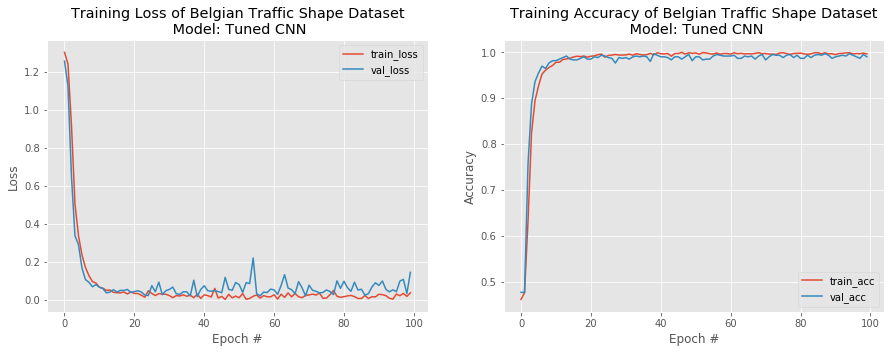

In [27]:
shapeTunedModelEval = shapeTunedModel.evaluate_generator(shapeTestGenerator, len(shapeTestDF))
print('test loss, test acc:', shapeTunedModelEval)
plot_accuracy(tunedModelPerformance, 100, "Tuned CNN")

In [28]:
shapeTestGenerator.reset()

shapeTunedModelPrediction = shapeTunedModel.predict_generator(shapeTestGenerator,verbose=1,steps=740/74)

shapeTunedModelPredictionNumLabels = np.argmax(shapeTunedModelPrediction,axis=1)

target_names = ['diamond', 'hex', 'round', 'square', 'triangle']
print(classification_report(shapeTestGenerator.classes,shapeTunedModelPredictionNumLabels, target_names=target_names))

27/27 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.96      0.98        56
         hex       1.00      0.78      0.88         9
       round       0.99      1.00      0.99       352
      square       0.99      1.00      0.99       138
    triangle       0.99      0.99      0.99       185

    accuracy                           0.99       740
   macro avg       0.99      0.95      0.97       740
weighted avg       0.99      0.99      0.99       740



## Independent Judgement - Shape Recognition 

### Dataset 1 - German road sign dataset - SHAPE MODEL


German Traffic sign sample size  (215, 2)


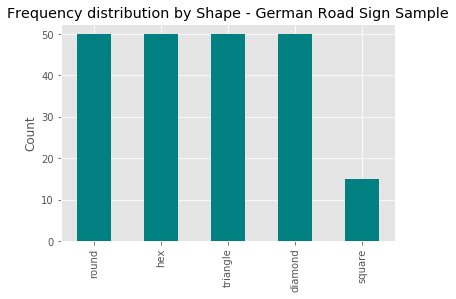

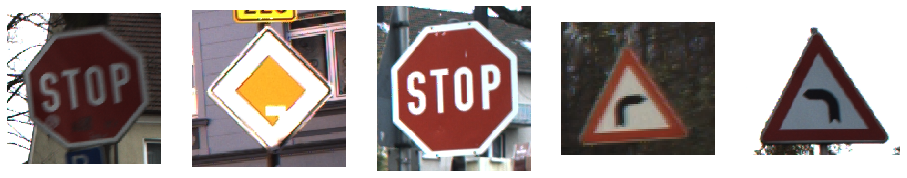

In [29]:
germanShapeImages = []
for filepath in glob.glob('./German Dataset Sample/shape/*/*.png', recursive=True): 
    
    shape = filepath.split("\\")[-2]
    germanShapeImages.append((filepath, shape))

germanDF = pd.DataFrame(data=germanShapeImages, columns=['path', 'shape' ])
print("German Traffic sign sample size ",germanDF.shape)

shapeMapping = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}

germanDF['shape_num'] = germanDF['shape'].map(shapeMapping, na_action='ignore')

germanDF.head()

shapeCount = germanDF['shape'].value_counts()
shapeCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Shape - German Road Sign Sample')
plt.ylabel('Count')
plt.show();

r_inx = np.random.choice(200,5)
rand_data = germanDF.loc[r_inx,'path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show();

In [30]:
shapeGermanDatagen = ImageDataGenerator(rescale=1. / 255)
shapeGermanGenerator = shapeGermanDatagen.flow_from_dataframe(
        dataframe=germanDF,
        directory='./',
        x_col="path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=shapeBatchSize,
        class_mode='categorical',
        shuffle=False)


shapeGermanGenerator.reset()

shapeTunedModelGermanPrediction = shapeTunedModel.predict_generator(shapeGermanGenerator,verbose=1,steps=215/5)

shapeTunedModelGermanPredictionNumLabels = np.argmax(shapeTunedModelGermanPrediction,axis=1)

target_names = target_names = [ 'diamond','hex', 'round', 'square', 'triangle']
print(classification_report(shapeGermanGenerator.classes,shapeTunedModelGermanPredictionNumLabels, target_names=target_names))

Found 215 validated image filenames belonging to 5 classes.
8/8 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

     diamond       0.97      0.64      0.77        50
         hex       1.00      0.54      0.70        50
       round       0.52      1.00      0.68        50
      square       0.58      0.47      0.52        15
    triangle       0.89      0.82      0.85        50

    accuracy                           0.73       215
   macro avg       0.79      0.69      0.71       215
weighted avg       0.83      0.73      0.74       215



### Dataset 2 - Chinese road sign dataset - SHAPE MODEL

Chinese Traffic sign sample size  (88, 2)


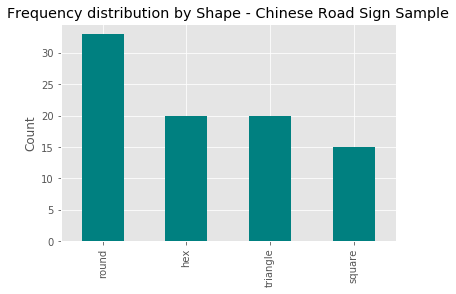

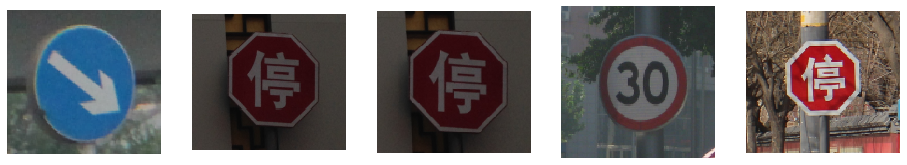

In [31]:
chineseShapeImages = []
for filepath in glob.glob('./Chinese Dataset Sample/shape/*/*.png', recursive=True):
    
    shape = filepath.split("\\")[-2]
    chineseShapeImages.append((filepath, shape))

chineseDF = pd.DataFrame(data=chineseShapeImages, columns=['path', 'shape' ])
print("Chinese Traffic sign sample size ",chineseDF.shape)

shapeMapping = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}

chineseDF['shape_num'] = chineseDF['shape'].map(shapeMapping, na_action='ignore')

chineseDF.head()

shapeCount = chineseDF['shape'].value_counts()
shapeCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Shape - Chinese Road Sign Sample')
plt.ylabel('Count')
plt.show();

r_inx = np.random.choice(76, 5)
rand_data = chineseDF.loc[r_inx,'path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show();

In [32]:
# Data preparation for tuning
shapeChineseImagesList = []


# Data of feature(image_path) and target variables(lables of shape and type)
imgPath = chineseDF.iloc[:,0]
shapeChineseLabels = chineseDF.iloc[:,2]

# Loading images into numpy array
for i in imgPath:
    tempImage = image.load_img(i, target_size=(28,28,1), grayscale=False)
    tempImage = image.img_to_array(tempImage)
    tempImage = tempImage/255
    shapeChineseImagesList.append(tempImage)

shapeChineseImages = np.array(shapeChineseImagesList)

shapeChinesePredictions = shapeTunedModel.predict_classes(shapeChineseImages)

# Make predictions
target_names = [ 'diamond','hex', 'round', 'square', 'triangle']
print(classification_report(shapeChineseLabels, shapeChinesePredictions, target_names=target_names))

              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00         0
         hex       0.00      0.00      0.00        20
       round       0.70      0.91      0.79        33
      square       0.39      0.60      0.47        15
    triangle       0.86      0.90      0.88        20

    accuracy                           0.65        88
   macro avg       0.39      0.48      0.43        88
weighted avg       0.52      0.65      0.58        88



# 7. Modeling Sign Target

### Baseline Neural Network Model

signModelNN = simpleNeuralNetwork(16)

In [33]:
signHyperTrainDF, signTestDF = train_test_split(trafficDF, random_state=677, test_size=0.2, stratify=trafficDF['sign_num'])
signTrainDF, signValidDF = train_test_split(signHyperTrainDF, random_state=41, test_size=0.2, stratify=signHyperTrainDF['sign_num'])

signTrainDF['sign_num'] = signTrainDF['sign_num'].astype('category')
signValidDF['sign_num'] = signValidDF['sign_num'].astype('category')
signTestDF['sign_num'] = signTestDF['sign_num'].astype('category')

In [34]:
signTrainDF.head()

,path,shape,sign,sign_num,shape_num
3207,./trafficsigns_dataset\triangle\warning\00327_...,triangle,warning,15,4
3461,./trafficsigns_dataset\triangle\warning\01139_...,triangle,warning,15,4
1089,./trafficsigns_dataset\round\noentry\01668_000...,round,noentry,4,2
3518,./trafficsigns_dataset\triangle\warning\01423_...,triangle,warning,15,4
4,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,rightofway,0,0


In [35]:
# Data generators for batching and efficient processing

# signTrainDatagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
signTrainDatagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2,  zoom_range=0.2,  rotation_range=20, data_format='channels_last')
signValidationDatagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

signTestDatagen = ImageDataGenerator(rescale=1. / 255)

signBatchSize = 28

signTrainGenerator = signTrainDatagen.flow_from_dataframe(
        dataframe=signTrainDF,
        directory='./',
        x_col="path",
        y_col="sign",
        target_size=(28, 28),
        batch_size=signBatchSize,
        class_mode='categorical')

signValidationGenerator = signValidationDatagen.flow_from_dataframe(
        dataframe=signValidDF,
        directory='./',
        x_col="path",
        y_col="sign",
        target_size=(28, 28),
        batch_size=signBatchSize,
        class_mode='categorical')

signTestGenerator = signTestDatagen.flow_from_dataframe(
        dataframe=signTestDF,
        directory='./',
        x_col="path",
        y_col="sign",
        target_size=(28, 28),
        batch_size=signBatchSize,
        class_mode='categorical',
        shuffle=False)

Found 2367 validated image filenames belonging to 16 classes.
Found 592 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [36]:
epochs = 170

img_width, img_height = 28, 28

signModelNN = simpleNeuralNetwork(16)

# fit and evaluate the model
signModelNN, signModelNNPerformance = fitModel(signModelNN, signTrainGenerator, signValidationGenerator, len(signTrainDF), len(signValidDF), signBatchSize, epochs, "Neural Network - sign")

Epoch 1/170
85/85 [==============================] - 2s 22ms/step - loss: 2.0737 - acc: 0.3937 - precision_3: 0.8344 - recall_3: 0.1065 - val_loss: 1.4113 - val_acc: 0.6250 - val_precision_3: 0.8571 - val_recall_3: 0.2939
Epoch 2/170
85/85 [==============================] - 2s 20ms/step - loss: 1.3660 - acc: 0.6362 - precision_3: 0.8446 - recall_3: 0.3329 - val_loss: 0.9283 - val_acc: 0.7314 - val_precision_3: 0.8770 - val_recall_3: 0.5422
Epoch 3/170
85/85 [==============================] - 2s 20ms/step - loss: 1.0769 - acc: 0.7169 - precision_3: 0.8590 - recall_3: 0.4736 - val_loss: 0.7255 - val_acc: 0.8125 - val_precision_3: 0.9115 - val_recall_3: 0.6436
Epoch 4/170
85/85 [==============================] - 2s 20ms/step - loss: 0.9096 - acc: 0.7512 - precision_3: 0.8855 - recall_3: 0.5653 - val_loss: 0.6584 - val_acc: 0.8412 - val_precision_3: 0.9279 - val_recall_3: 0.6959
Epoch 5/170
85/85 [==============================] - 2s 21ms/step - loss: 0.7980 - acc: 0.7828 - precision_3: 0.

test loss, test acc: [0.16914043933394607, 0.95135134, 0.9591281, 0.95135134]


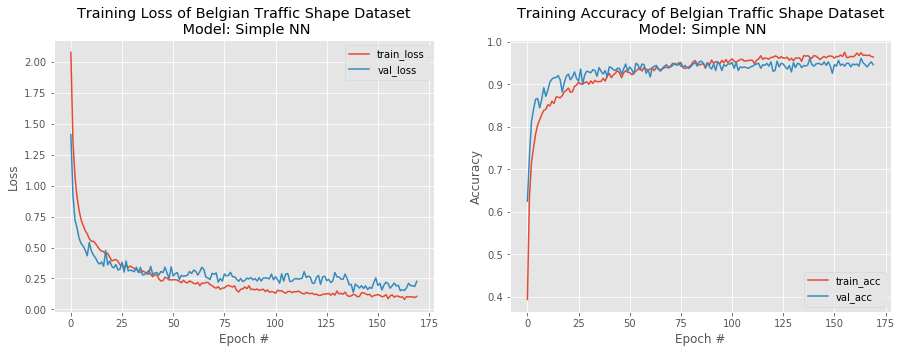

In [37]:
signTestNNResult = signModelNN.evaluate_generator(signTestGenerator, len(signTestDF))
print('test loss, test acc:', signTestNNResult)
plot_accuracy(signModelNNPerformance, epochs, "Simple NN")

## CNN Model for sign target

In [38]:
#define CNN modelCNN to be used for training our image classificatin data
def signCNN(denseLayerSizes, filters, kernelSize, poolSize, optimizer='rmsprop', init='glorot_uniform', learningRate = 0.0001, momentumVal = 0.9, cLayers = 3):
    modelCNN = ""  
    modelCNN = Sequential()
    
    # Input layer
    modelCNN.add(InputLayer(input_shape=(28, 28,3)))
    modelCNN.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)))

    # Dynamically add convulation and pooling layers as per hyper-parameter cLayers (minimum 1)
    for i in range(cLayers):
        multiplier = 2 * i if i > 0 else 1
        modelCNN.add(Conv2D((multiplier) * filters, kernelSize, padding='same'))
        modelCNN.add(Activation('relu'))
        modelCNN.add(Conv2D((multiplier) * filters, kernelSize, padding='same'))
        modelCNN.add(Activation('relu'))
        modelCNN.add(MaxPooling2D(pool_size=poolSize))
        modelCNN.add(Dropout(0.125))

    # MLP
    modelCNN.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    for layer_size in denseLayerSizes:
        modelCNN.add(Dense(layer_size))
        modelCNN.add(Activation('relu'))
    modelCNN.add(Dropout(0.4))
    modelCNN.add(Dense(16))
    modelCNN.add(Activation('softmax'))

    opt = keras.optimizers.RMSprop(lr=learningRate, decay=1e-6)
#     sgd = optimizers.SGD(lr=learningRate, decay=1e-6, momentum= momentumVal, nesterov=True)
    modelCNN.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    # save the weights so that we can start from the same place when tring different configurations
    modelCNN.save_weights('modelCNN.h5')
    
#     modelCNN.summary()
        
    return modelCNN

In [39]:
# Data preparation for tuning
signHyperTrainImagesList = []
signHyperTestImagesList = []


# Data of feature(image_path) and target variables(lables of sign and type)
imgPath = signHyperTrainDF.iloc[:,0]
signHyperTrainLabels = signHyperTrainDF.iloc[:,3]

# Loading images into numpy array
for i in imgPath:
    tempImage = image.load_img(i, target_size=(28,28,1), grayscale=False)
    tempImage = image.img_to_array(tempImage)
    tempImage = tempImage/255
    signHyperTrainImagesList.append(tempImage)

signHyperTrainImages = np.array(signHyperTrainImagesList)

# Coverting lables type to catagorical
signHyperTrainLabels = tf.keras.utils.to_categorical(signHyperTrainLabels)

# 8. Hyper parameter tuning for Sign Target

In [40]:
signHyperModel = KerasClassifier(build_fn=signCNN, verbose=True)

epochs = [130,150]
filters = [8,16]
poolSize = [2,3]
kernelSize = [3, 5]
batchSize = [28, 32,56]
cLayers = [2,3]
denseLayerSize = [[1024], [1024,512,256], [1024, 512]]
learnRate = [0.001, 0.01, 0.1, 1]


paramGrid = dict(batch_size=batchSize, epochs=epochs, 
    denseLayerSizes = denseLayerSize, filters = filters , kernelSize = kernelSize , poolSize = poolSize, cLayers = cLayers, learningRate = learnRate)

signGrid = RandomizedSearchCV(estimator=signHyperModel , param_distributions=paramGrid, n_jobs=1, n_iter= 15, cv=2)

start_time = time.time()
#signGridResult = signGrid.fit(signHyperTrainImages, np.array(signHyperTrainLabels))
print("tuning time", str(time.time() - start_time), "seconds")

tuning time 0.0 seconds


In [41]:
# summarize results
# print("Best: %f using %s" % (signGridResult.best_score_, signGridResult.best_params_))
# means = signGridResult.cv_results_['mean_test_score']
# stds = signGridResult.cv_results_['std_test_score']
# params = signGridResult.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
    
# Output of tuning
    
# Best: 0.976681 using {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 16, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 32}
# 0.972288 (0.004065) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 5, 'filters': 8, 'epochs': 130, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 56}
# 0.187901 (0.003443) with: {'poolSize': 2, 'learningRate': 1, 'kernelSize': 5, 'filters': 8, 'epochs': 130, 'denseLayerSizes': [1024], 'cLayers': 3, 'batch_size': 32}
# 0.145319 (0.039153) with: {'poolSize': 3, 'learningRate': 0.1, 'kernelSize': 5, 'filters': 16, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 56}
# 0.116255 (0.068227) with: {'poolSize': 3, 'learningRate': 1, 'kernelSize': 3, 'filters': 8, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 56}
# 0.187901 (0.003443) with: {'poolSize': 2, 'learningRate': 1, 'kernelSize': 3, 'filters': 8, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 28}
# 0.187901 (0.003443) with: {'poolSize': 2, 'learningRate': 0.01, 'kernelSize': 5, 'filters': 8, 'epochs': 150, 'denseLayerSizes': [1024], 'cLayers': 2, 'batch_size': 28}
# 0.973302 (0.004402) with: {'poolSize': 3, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 16, 'epochs': 130, 'denseLayerSizes': [1024], 'cLayers': 3, 'batch_size': 56}
# 0.976681 (0.000346) with: {'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 16, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 32}
# 0.135857 (0.055470) with: {'poolSize': 3, 'learningRate': 1, 'kernelSize': 5, 'filters': 16, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 2, 'batch_size': 28}
# 0.187901 (0.003443) with: {'poolSize': 3, 'learningRate': 1, 'kernelSize': 3, 'filters': 8, 'epochs': 130, 'denseLayerSizes': [1024, 512, 256], 'cLayers': 3, 'batch_size': 56}

## Preparing tuned model for testing and independent evaluation

In [42]:
#{'poolSize': 2, 'learningRate': 0.001, 'kernelSize': 3, 'filters': 16, 'epochs': 150, 'denseLayerSizes': [1024, 512], 'cLayers': 3, 'batch_size': 32}

signTunedModel = signCNN(denseLayerSizes = [512], filters = 16, kernelSize =3, poolSize = 2, learningRate= 0.001, cLayers = 3)

# # fit and evaluate the model
signTunedModel, signTunedModelPerformance = fitModel(signTunedModel, signTrainGenerator, signValidationGenerator, len(signTrainDF), len(signValidDF), 32, 150, "CNN - sign")

Epoch 1/150
85/85 [==============================] - 2s 28ms/step - loss: 2.2053 - acc: 0.3211 - precision_4: 0.7154 - recall_4: 0.1115 - val_loss: 1.5660 - val_acc: 0.5389 - val_precision_4: 0.6737 - val_recall_4: 0.3801
Epoch 2/150
85/85 [==============================] - 2s 23ms/step - loss: 1.2367 - acc: 0.6333 - precision_4: 0.7963 - recall_4: 0.4575 - val_loss: 0.6156 - val_acc: 0.8176 - val_precision_4: 0.8827 - val_recall_4: 0.7500
Epoch 3/150
85/85 [==============================] - 2s 21ms/step - loss: 0.7155 - acc: 0.7824 - precision_4: 0.8627 - recall_4: 0.6984 - val_loss: 0.3945 - val_acc: 0.8818 - val_precision_4: 0.9240 - val_recall_4: 0.8209
Epoch 4/150
85/85 [==============================] - 2s 22ms/step - loss: 0.5242 - acc: 0.8281 - precision_4: 0.8783 - recall_4: 0.7778 - val_loss: 0.2149 - val_acc: 0.9358 - val_precision_4: 0.9443 - val_recall_4: 0.9172
Epoch 5/150
85/85 [==============================] - 2s 24ms/step - loss: 0.3940 - acc: 0.8728 - precision_4: 0.

test loss, test acc: [0.1358082796367194, 0.98108107, 0.98240864, 0.98108107]


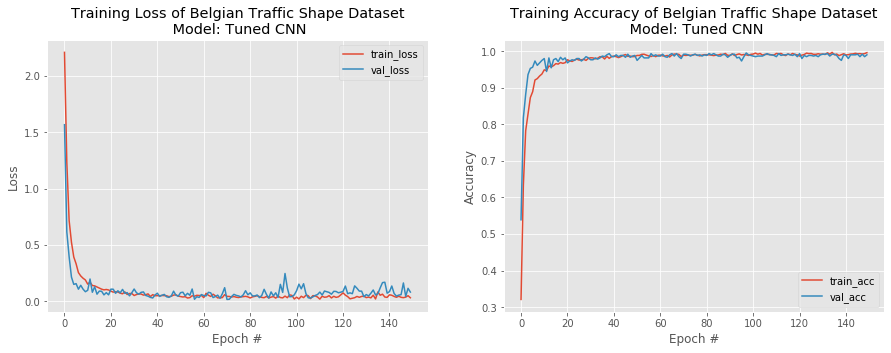

In [43]:
signTunedModelEval = signTunedModel.evaluate_generator(signTestGenerator, len(signTestDF))
print('test loss, test acc:', signTunedModelEval)
plot_accuracy(signTunedModelPerformance, 150, "Tuned CNN")

In [44]:
signTestGenerator.reset()

signTunedModelPrediction = signTunedModel.predict_generator(signTestGenerator,verbose=1,steps=740/74)

signTunedModelPredictionNumLabels = np.argmax(signTunedModelPrediction,axis=1)

target_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue',
               'crossing', 'laneend', 'parking', 'giveway', 'warning']
print(classification_report(signTestGenerator.classes,signTunedModelPredictionNumLabels, target_names=target_names))

27/27 [==============================] - 0s 12ms/step
                  precision    recall  f1-score   support

      rightofway       1.00      1.00      1.00        57
            stop       1.00      1.00      1.00        40
         bicycle       0.90      1.00      0.95        19
  limitedtraffic       0.98      1.00      0.99        46
         noentry       1.00      1.00      1.00        24
       noparking       0.92      0.92      0.92        25
      roundabout       0.96      0.96      0.96        75
           speed       0.96      1.00      0.98        48
trafficdirective       1.00      1.00      1.00        55
 traveldirection       1.00      0.96      0.98        56
        continue       1.00      1.00      1.00        20
        crossing       1.00      1.00      1.00        63
         laneend       1.00      0.89      0.94         9
         parking       0.93      1.00      0.96        39
         giveway       0.96      0.88      0.92        25
         warning 

## Independent Judgement - Sign Recognition 

### Dataset 1 - German road sign dataset - SIGN MODEL


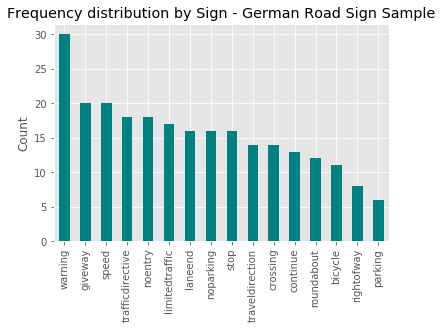

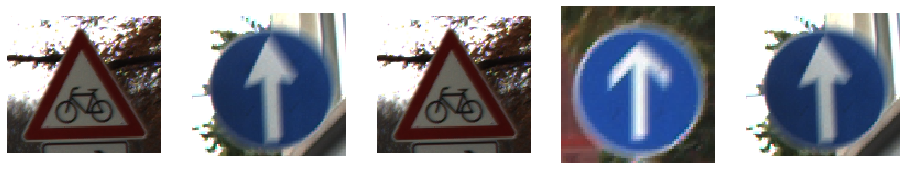

In [45]:
germanSignImages = []
for filepath in glob.glob('./German Dataset Sample/sign/*/*.png', recursive=True): 
    
    sign = filepath.split("\\")[-2]
    germanSignImages.append((filepath, sign))

germanDF = pd.DataFrame(data=germanSignImages, columns=['path', 'sign' ])


signMapping = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10,
               'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

germanDF['sign_num'] = germanDF['sign'].map(signMapping, na_action='ignore')



signCount = germanDF['sign'].value_counts()
signCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Sign - German Road Sign Sample')
plt.ylabel('Count')
plt.show();

r_inx = np.random.choice(20,5)
rand_data = germanDF.loc[r_inx,'path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show();

In [46]:
signGermanDatagen = ImageDataGenerator(rescale=1. / 255)
signGermanGenerator = signGermanDatagen.flow_from_dataframe(
        dataframe=germanDF,
        directory='./',
        x_col="path",
        y_col="sign",
        target_size=(28, 28),
        batch_size=signBatchSize,
        class_mode='categorical',
        shuffle=False)


signGermanGenerator.reset()

signTunedModelGermanPrediction = signTunedModel.predict_generator(signGermanGenerator,verbose=1,steps=740/74)

signTunedModelGermanPredictionNumLabels = np.argmax(signTunedModelGermanPrediction,axis=1)

target_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue',
               'crossing', 'laneend', 'parking', 'giveway', 'warning']
print(classification_report(signGermanGenerator.classes,signTunedModelGermanPredictionNumLabels, target_names=target_names))

Found 249 validated image filenames belonging to 16 classes.
9/9 [==============================] - 0s 43ms/step
                  precision    recall  f1-score   support

      rightofway       0.00      0.00      0.00        11
            stop       0.77      0.77      0.77        13
         bicycle       0.00      0.00      0.00        14
  limitedtraffic       1.00      0.90      0.95        20
         noentry       0.00      0.00      0.00        16
       noparking       0.76      0.94      0.84        17
      roundabout       0.93      0.72      0.81        18
           speed       0.11      0.06      0.08        16
trafficdirective       0.83      0.83      0.83         6
 traveldirection       0.83      0.62      0.71         8
        continue       0.90      0.75      0.82        12
        crossing       0.83      0.95      0.88        20
         laneend       1.00      0.81      0.90        16
         parking       0.93      0.72      0.81        18
         giveway

### Dataset 2 - Chinese road sign dataset - SIGN MODEL

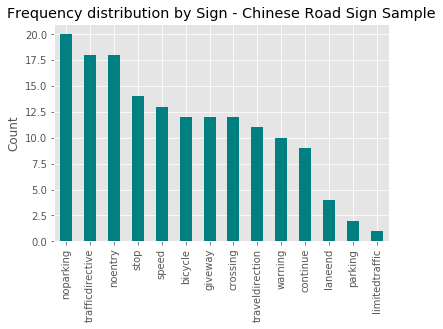

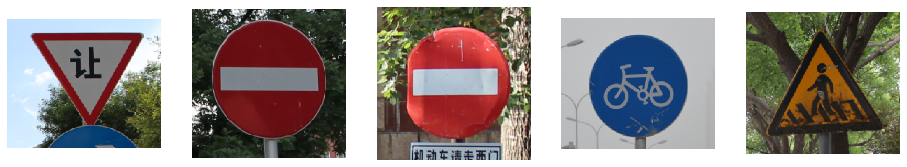

In [47]:
chineseSignImages = []
for filepath in glob.glob('./Chinese Dataset Sample/sign/*/*.png', recursive=True):
    
    sign = filepath.split("\\")[-2]
    chineseSignImages.append((filepath, sign))

chineseDF = pd.DataFrame(data=chineseSignImages, columns=['path', 'sign' ])


signMapping = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10,
               'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

chineseDF['sign_num'] = chineseDF['sign'].map(signMapping, na_action='ignore')

chineseDF.head()

signCount = chineseDF['sign'].value_counts()
signCount.plot(kind ='bar', color='teal')
plt.title('Frequency distribution by Sign - Chinese Road Sign Sample')
plt.ylabel('Count')
plt.show();

r_inx = np.random.choice(76, 5)
rand_data = chineseDF.loc[r_inx,'path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show();

In [48]:
signChineseDatagen = ImageDataGenerator(rescale=1. / 255)
signChineseGenerator = signChineseDatagen.flow_from_dataframe(
        dataframe=chineseDF,
        directory='./',
        x_col="path",
        y_col="sign",
        target_size=(28, 28),
        batch_size=signBatchSize,
        class_mode='categorical',
        shuffle=False)


signChineseGenerator.reset()

signTunedModelChinesePrediction = signTunedModel.predict_generator(signChineseGenerator,verbose=1,steps=740/74)

signTunedModelChinesePredictionNumLabels = np.argmax(signTunedModelChinesePrediction,axis=1)

target_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue',
               'crossing', 'laneend', 'parking', 'giveway', 'warning']
print(classification_report(signChineseGenerator.classes,signTunedModelChinesePredictionNumLabels, target_names=target_names))

Found 156 validated image filenames belonging to 14 classes.
6/6 [==============================] - 0s 46ms/step
                  precision    recall  f1-score   support

      rightofway       0.50      1.00      0.67        12
            stop       0.90      1.00      0.95         9
         bicycle       1.00      0.17      0.29        12
  limitedtraffic       0.80      0.33      0.47        12
         noentry       0.00      0.00      0.00         4
       noparking       0.11      1.00      0.20         1
      roundabout       1.00      0.22      0.36        18
           speed       0.11      0.05      0.07        20
trafficdirective       0.50      1.00      0.67         2
 traveldirection       0.00      0.00      0.00        13
        continue       0.00      0.00      0.00        14
        crossing       0.21      0.17      0.19        18
         laneend       0.00      0.00      0.00        11
         parking       0.00      0.00      0.00        10
         giveway